# Feature Fusion Analysis

This notebook analyzes the feature fusion methods implemented in the `feature_fusion.py` module. We'll explore different techniques for transforming and combining heterogeneous data from the Power and HPC-Kernel-Events datasets into the same latent space while addressing concept drift issues.

## 1. Setup and Data Loading

In [20]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Add parent directory to path to import modules
sys.path.append('..')

# Import custom modules
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from src.feature_fusion import (
    load_processed_data,
    extract_features,
    feature_concatenation,
    weighted_feature_fusion,
    fusion_with_dim_reduction,
    cca_fusion,
    kernel_fusion,
    supervised_fusion,
    domain_adaptation_fusion,
    detect_concept_drift,
    create_tsne_visualization,
    get_fused_features
)

In [21]:
# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(context='notebook', style='whitegrid', palette='colorblind', font_scale=1.2)

# Create a results directory
NOTEBOOK_RESULTS_DIR = Path('../results/feature_fusion_analysis')
NOTEBOOK_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Results will be saved to {NOTEBOOK_RESULTS_DIR}")

Results will be saved to ..\results\feature_fusion_analysis


In [22]:
# Load processed data
power_df, hpc_df = load_processed_data()

if power_df is None or hpc_df is None:
    print("Error loading data. Please make sure the preprocessed data files exist.")
else:
    print(f"Loaded Power dataset: {power_df.shape}")
    print(f"Loaded HPC dataset: {hpc_df.shape}")

Loaded Power dataset with shape: (129661, 8)
Loaded HPC dataset with shape: (6166, 37)
Loaded Power dataset: (129661, 8)
Loaded HPC dataset: (6166, 37)


In [23]:
# Extract features and labels
X_power, y_power, X_hpc, y_hpc = extract_features(power_df, hpc_df)

print(f"Power features shape: {X_power.shape}, labels shape: {y_power.shape}")
print(f"HPC features shape: {X_hpc.shape}, labels shape: {y_hpc.shape}")

Extracted Power features: (129661, 7), labels: (129661,)
Extracted HPC features: (6166, 36), labels: (6166,)
Power features shape: (129661, 7), labels shape: (129661,)
HPC features shape: (6166, 36), labels shape: (6166,)


## 2. Exploratory Data Analysis of Datasets

In [24]:
# Display basic statistics for both datasets
print("\nPower Dataset Statistics:")
print(X_power.describe())

print("\nHPC Dataset Statistics:")
print(X_hpc.describe())


Power Dataset Statistics:
       shunt_voltage  bus_voltage_V     current_mA       power_mW  \
count  129661.000000  129661.000000  129661.000000  129661.000000   
mean       -0.043437       0.051885      -0.044155      -0.043896   
std         0.965939       0.968371       0.966162       0.966103   
min        -1.028402      -2.707098      -1.027614      -1.040750   
25%        -0.774836      -0.497438      -0.774208      -0.783722   
50%        -0.546627       0.607391      -0.546143      -0.546465   
75%         0.376353       0.883599       0.380478       0.382790   
max         3.013437       1.436014       3.042081       3.051927   

          State_idle  interface_none  interface_ocpp  
count  129661.000000   129661.000000   129661.000000  
mean       -0.061561        0.293653       -0.133304  
std         1.031896        1.257561        1.015815  
min        -1.701800       -0.377226       -1.203390  
25%        -1.701800       -0.377226       -1.203390  
50%         0.587613 

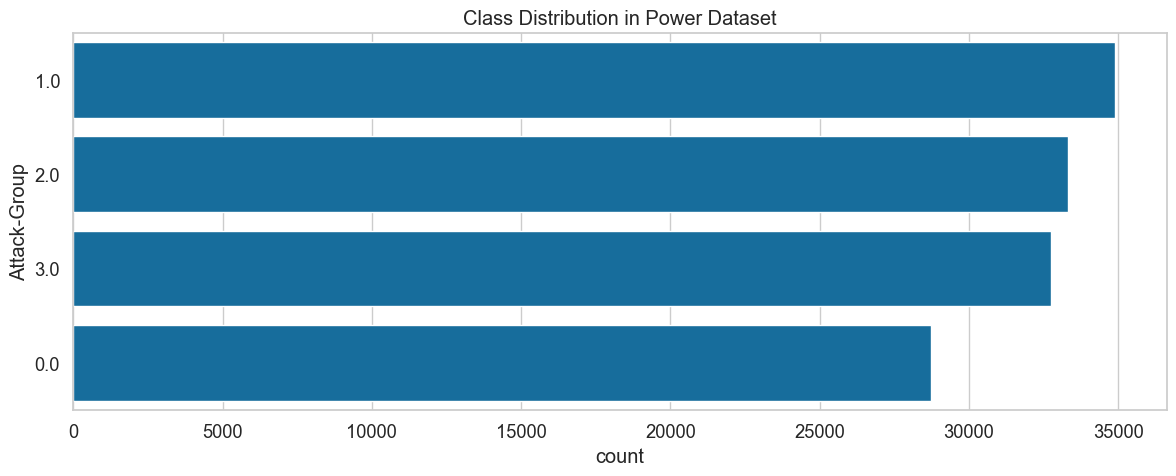

In [25]:
# Check class distribution in Power dataset
plt.figure(figsize=(12, 5))
sns.countplot(y=y_power, order=y_power.value_counts().index)
plt.title('Class Distribution in Power Dataset')
plt.tight_layout()
plt.savefig(NOTEBOOK_RESULTS_DIR / 'power_class_distribution.png', dpi=300)
plt.show()

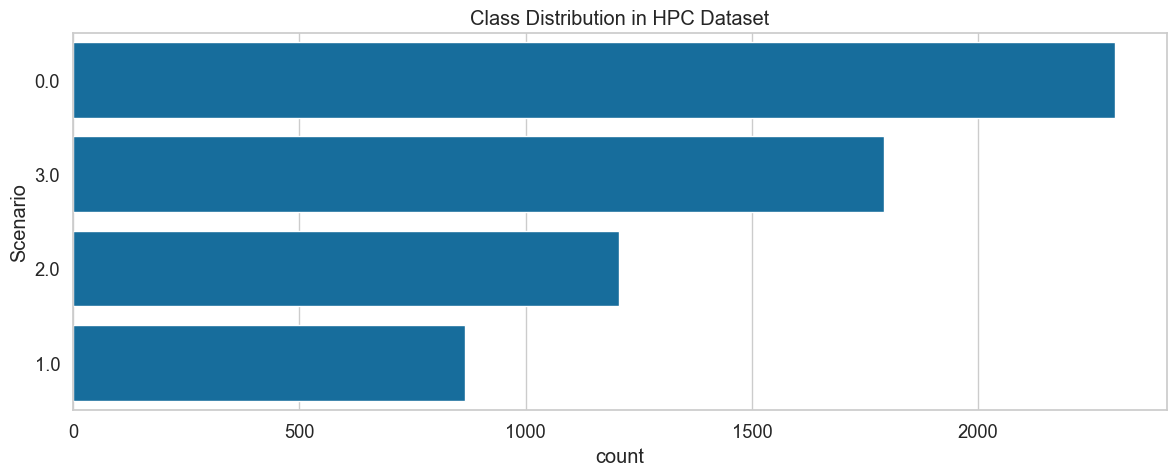

In [26]:
# Check class distribution in HPC dataset
plt.figure(figsize=(12, 5))
sns.countplot(y=y_hpc, order=y_hpc.value_counts().index)
plt.title('Class Distribution in HPC Dataset')
plt.tight_layout()
plt.savefig(NOTEBOOK_RESULTS_DIR / 'hpc_class_distribution.png', dpi=300)
plt.show()

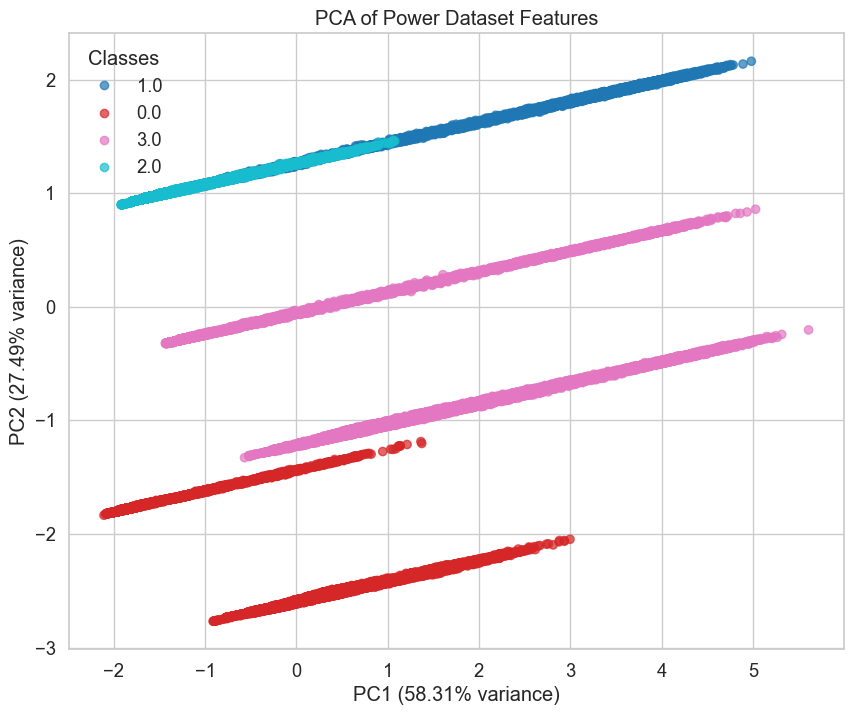

In [27]:
# PCA visualization of Power dataset
scaler = StandardScaler()
X_power_scaled = scaler.fit_transform(X_power)

pca = PCA(n_components=2)
X_power_pca = pca.fit_transform(X_power_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_power_pca[:, 0], X_power_pca[:, 1], c=pd.factorize(y_power)[0], cmap='tab10', alpha=0.7)

# Create legend
labels = y_power.unique()
handles = scatter.legend_elements()[0]
plt.legend(handles, labels, title="Classes")

plt.title(f'PCA of Power Dataset Features')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig(NOTEBOOK_RESULTS_DIR / 'power_pca.png', dpi=300)
plt.show()

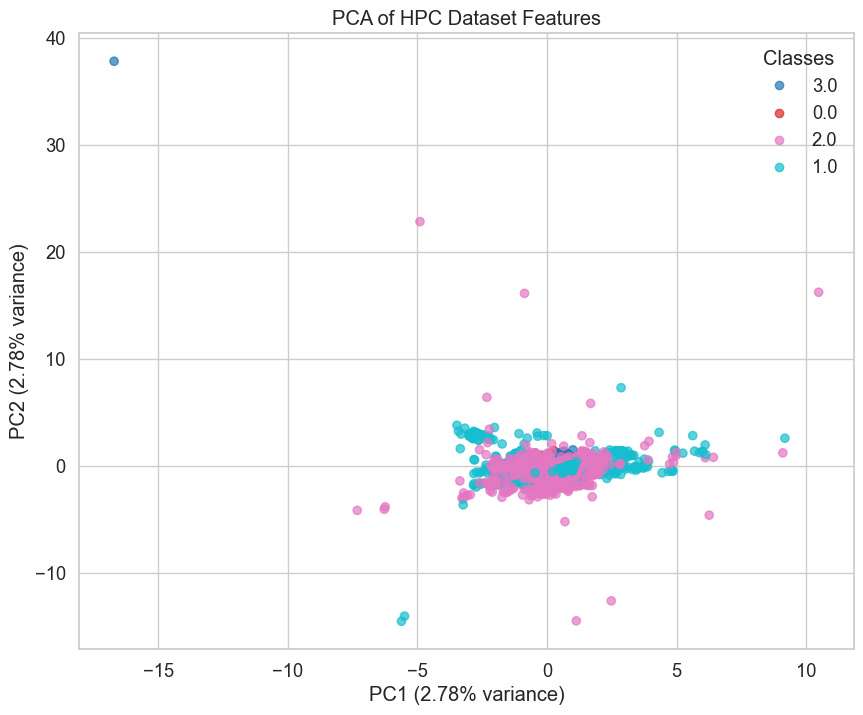

In [28]:
# PCA visualization of HPC dataset
scaler = StandardScaler()
X_hpc_scaled = scaler.fit_transform(X_hpc)

pca = PCA(n_components=2)
X_hpc_pca = pca.fit_transform(X_hpc_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_hpc_pca[:, 0], X_hpc_pca[:, 1], c=pd.factorize(y_hpc)[0], cmap='tab10', alpha=0.7)

# Create legend
labels = y_hpc.unique()
handles = scatter.legend_elements()[0]
plt.legend(handles, labels, title="Classes")

plt.title(f'PCA of HPC Dataset Features')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig(NOTEBOOK_RESULTS_DIR / 'hpc_pca.png', dpi=300)
plt.show()

## 3. Concept Drift Analysis

In [29]:
# Analyze concept drift between datasets
# We need to make sure datasets have the same dimensionality for this analysis
if X_power.shape[1] != X_hpc.shape[1]:
    print("Datasets have different dimensionality, adjusting for comparison...")
    # Find common dimensionality
    common_dim = min(X_power.shape[1], X_hpc.shape[1])
    
    # Apply PCA to reduce to common dimensionality
    pca_power = PCA(n_components=common_dim)
    pca_hpc = PCA(n_components=common_dim)
    
    X_power_common = pca_power.fit_transform(X_power)
    X_hpc_common = pca_hpc.fit_transform(X_hpc)
    
    print(f"Reduced dimensionality to {common_dim} features")
    
    drift_score = detect_concept_drift(X_power_common, X_hpc_common)
else:
    drift_score = detect_concept_drift(X_power.values, X_hpc.values)

print(f"\nOverall concept drift score: {drift_score:.4f}")
print("Higher score indicates more drift between datasets.")

Datasets have different dimensionality, adjusting for comparison...
Reduced dimensionality to 7 features
Concept Drift Analysis:
  Mean difference: 0.0000
  Std difference: 10.5632
  Cosine similarity: 0.7798
  Average distance: 12.0444
  Overall drift score: 2.9969

Overall concept drift score: 2.9969
Higher score indicates more drift between datasets.


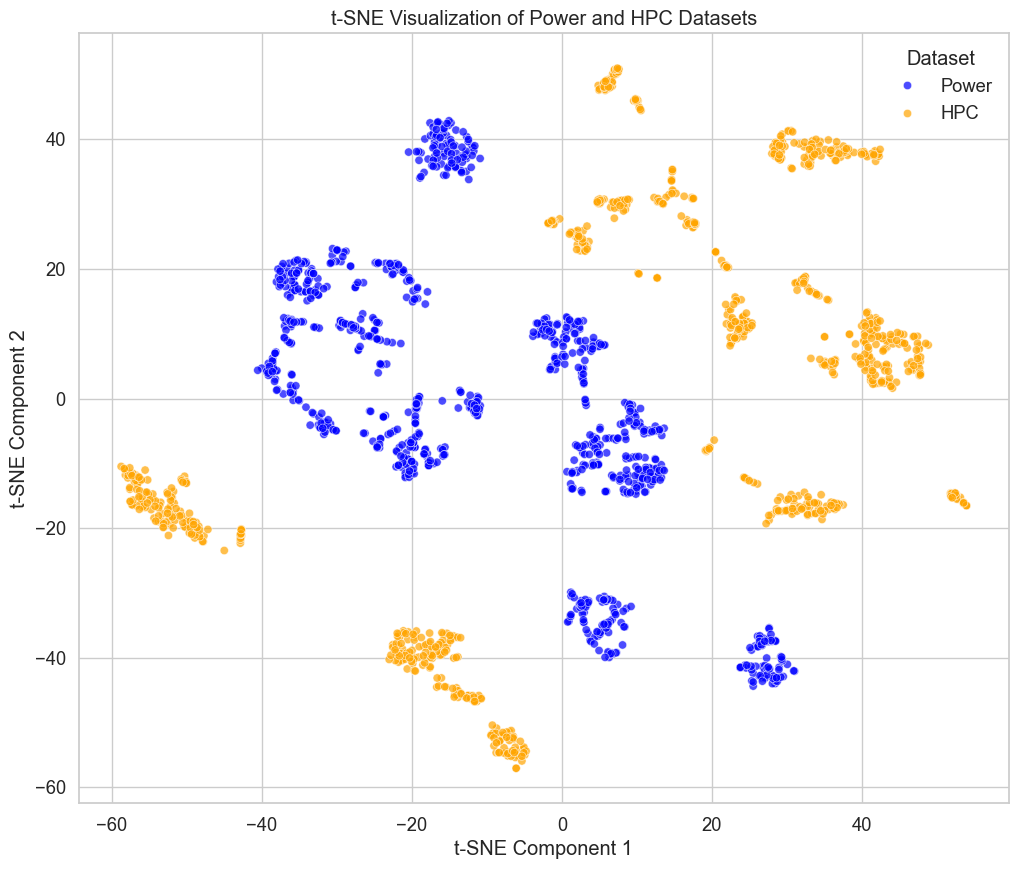

In [30]:
# Visualize both datasets together using t-SNE
# Sample data if datasets are large
max_samples = 1000
if X_power.shape[0] > max_samples:
    indices = np.random.choice(X_power.shape[0], max_samples, replace=False)
    X_power_sample = X_power.iloc[indices].values
    y_power_sample = y_power.iloc[indices]
else:
    X_power_sample = X_power.values
    y_power_sample = y_power

if X_hpc.shape[0] > max_samples:
    indices = np.random.choice(X_hpc.shape[0], max_samples, replace=False)
    X_hpc_sample = X_hpc.iloc[indices].values
    y_hpc_sample = y_hpc.iloc[indices]
else:
    X_hpc_sample = X_hpc.values
    y_hpc_sample = y_hpc

# Ensure same dimensionality
if X_power_sample.shape[1] != X_hpc_sample.shape[1]:
    min_dim = min(X_power_sample.shape[1], X_hpc_sample.shape[1])
    pca = PCA(n_components=min_dim)
    X_power_sample = pca.fit_transform(X_power_sample)
    X_hpc_sample = pca.fit_transform(X_hpc_sample)

# Scale data
scaler = StandardScaler()
X_power_scaled = scaler.fit_transform(X_power_sample)
X_hpc_scaled = scaler.transform(X_hpc_sample)  # Use same scaler for both

# Combine for t-SNE
X_combined = np.vstack([X_power_scaled, X_hpc_scaled])
dataset_labels = np.array(['Power'] * len(X_power_scaled) + ['HPC'] * len(X_hpc_scaled))

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dataset_labels, palette=['blue', 'orange'], alpha=0.7)
plt.title('t-SNE Visualization of Power and HPC Datasets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Dataset')
plt.savefig(NOTEBOOK_RESULTS_DIR / 'tsne_both_datasets.png', dpi=300)
plt.show()

## 4. Analysis of Feature Fusion Methods

Now we'll implement and compare different feature fusion methods.

In [31]:
# Function to evaluate clustering quality
def evaluate_clustering(X, y_true, n_clusters=None):
    """Evaluate clustering quality using various metrics."""
    if n_clusters is None:
        n_clusters = len(np.unique(y_true))
    
    # Convert labels to numeric
    if not pd.api.types.is_numeric_dtype(y_true):
        y_numeric = pd.factorize(y_true)[0]
    else:
        y_numeric = y_true
        
    # Run K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)
    
    # Calculate metrics
    metrics = {
        'silhouette': silhouette_score(X, y_pred),
        'adjusted_rand': adjusted_rand_score(y_numeric, y_pred),
        'davies_bouldin': davies_bouldin_score(X, y_pred),
        'calinski_harabasz': calinski_harabasz_score(X, y_pred)
    }
    
    return metrics, y_pred

In [32]:
# Function to evaluate classification performance
def evaluate_classification(X, y):
    """Evaluate classification performance using Random Forest."""
    # Convert labels to numeric
    if not pd.api.types.is_numeric_dtype(y):
        label_mapping = {label: i for i, label in enumerate(np.unique(y))}
        y_numeric = np.array([label_mapping[label] for label in y])
    else:
        y_numeric = y
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_numeric, test_size=0.3, random_state=42, stratify=y_numeric
    )
    
    # Train classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'model': clf,
        'classification_report': classification_report(y_test, y_pred)
    }

In [33]:
# Function to visualize fusion results
def visualize_fusion_results(X_fused, labels, method_name):
    """Visualize fusion results using PCA and t-SNE."""
    # Create subplot with PCA and t-SNE
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # PCA visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_fused)
    
    if not pd.api.types.is_numeric_dtype(labels):
        label_values = pd.factorize(labels)[0]
    else:
        label_values = labels
    
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=label_values, cmap='tab10', alpha=0.7)
    axes[0].set_title(f'PCA - {method_name}')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_fused)
    
    scatter = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_values, cmap='tab10', alpha=0.7)
    axes[1].set_title(f't-SNE - {method_name}')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    
    # Try to add a legend if not too many classes
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 10:
        handles = scatter.legend_elements()[0]
        fig.legend(handles, unique_labels, title="Classes", loc="center right")
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_RESULTS_DIR / f'visualization_{method_name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()
    
    return X_pca, X_tsne

### 4.3 PCA-based Fusion

In [34]:
# Apply PCA-based feature fusion
print("Applying PCA-based fusion...")
X_pca_fusion, pca_model = fusion_with_dim_reduction(X_power, X_hpc, n_components=0.95)
print(f"PCA fusion shape: {X_pca_fusion.shape}")
print(f"Explained variance: {pca_model.explained_variance_ratio_.sum():.2%}")

# Evaluate clustering
pca_cluster_metrics, pca_clusters = evaluate_clustering(X_pca_fusion, y_power)
print("\nClustering Metrics for PCA-based Fusion:")
for metric, value in pca_cluster_metrics.items():
    print(f"{metric}: {value:.4f}")

# Evaluate classification
pca_class_metrics = evaluate_classification(X_pca_fusion, y_power)
print(f"\nClassification Performance:")
print(f"Accuracy: {pca_class_metrics['accuracy']:.4f}")
print(f"F1 Score: {pca_class_metrics['f1_score']:.4f}")
print("\nClassification Report:")
print(pca_class_metrics['classification_report'])

# Visualize results
visualize_fusion_results(X_pca_fusion, y_power, "PCA Fusion")

Applying PCA-based fusion...
Using only the first min(n_power, n_hpc) samples from each dataset
Combined feature matrix shape: (6166, 43)
Number of Power features: 7
Number of HPC features: 36
Number of components after PCA: 36
Explained variance ratio: 0.9650
PCA fusion shape: (6166, 36)
Explained variance: 96.50%


ValueError: Found input variables with inconsistent numbers of samples: [129661, 6166]

### 4.4 CCA Fusion

In [35]:
# Apply CCA fusion
print("Applying CCA fusion...")
try:
    # Determine the number of components for CCA
    n_components = min(10, min(X_power.shape[1], X_hpc.shape[1]), min(X_power.shape[0], X_hpc.shape[0]) - 1)
    print(f"Using {n_components} components for CCA")
    
    X_cca_power, X_cca_hpc, X_cca_combined, cca_model = cca_fusion(X_power, X_hpc, n_components=n_components)
    print(f"CCA combined shape: {X_cca_combined.shape}")
    
    # Evaluate clustering
    cca_cluster_metrics, cca_clusters = evaluate_clustering(X_cca_combined, y_power)
    print("\nClustering Metrics for CCA Fusion:")
    for metric, value in cca_cluster_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Evaluate classification
    cca_class_metrics = evaluate_classification(X_cca_combined, y_power)
    print(f"\nClassification Performance:")
    print(f"Accuracy: {cca_class_metrics['accuracy']:.4f}")
    print(f"F1 Score: {cca_class_metrics['f1_score']:.4f}")
    print("\nClassification Report:")
    print(cca_class_metrics['classification_report'])
    
    # Visualize results
    visualize_fusion_results(X_cca_combined, y_power, "CCA Fusion")
except Exception as e:
    print(f"Error with CCA fusion: {e}")

Applying CCA fusion...
Using 7 components for CCA
Using only the first min(n_power, n_hpc) samples from each dataset
CCA transformed Power shape: (6166, 7)
CCA transformed HPC shape: (6166, 7)
Combined CCA features shape: (6166, 14)
CCA combined shape: (6166, 14)
Error with CCA fusion: Found input variables with inconsistent numbers of samples: [129661, 6166]


### 4.5 Kernel-based Fusion

In [ ]:
# Apply kernel-based fusion
print("Applying kernel-based fusion...")
try:
    # Sample data if too large to avoid memory issues with kernel methods
    max_samples = 2000
    if X_power.shape[0] > max_samples:
        print(f"Sampling {max_samples} data points for kernel fusion due to memory constraints")
        X_power_sample = X_power.sample(max_samples, random_state=42)
        y_power_sample = y_power[X_power_sample.index]
        X_hpc_sample = X_hpc.sample(max_samples, random_state=42)
    else:
        X_power_sample = X_power
        y_power_sample = y_power
        X_hpc_sample = X_hpc
    
    X_kernel, kpca_model = kernel_fusion(X_power_sample, X_hpc_sample, kernel='rbf')
    print(f"Kernel fusion shape: {X_kernel.shape}")
    
    # Evaluate clustering
    kernel_cluster_metrics, kernel_clusters = evaluate_clustering(X_kernel, y_power_sample)
    print("\nClustering Metrics for Kernel-based Fusion:")
    for metric, value in kernel_cluster_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Evaluate classification
    kernel_class_metrics = evaluate_classification(X_kernel, y_power_sample)
    print(f"\nClassification Performance:")
    print(f"Accuracy: {kernel_class_metrics['accuracy']:.4f}")
    print(f"F1 Score: {kernel_class_metrics['f1_score']:.4f}")
    print("\nClassification Report:")
    print(kernel_class_metrics['classification_report'])
    
    # Visualize results
    visualize_fusion_results(X_kernel, y_power_sample, "Kernel Fusion")
except Exception as e:
    print(f"Error with kernel fusion: {e}")

Applying kernel-based fusion...
Sampling 2000 data points for kernel fusion due to memory constraints
Combined feature matrix shape: (2000, 43)
Number of Power features: 7
Number of HPC features: 36
Error with kernel fusion: The 'n_components' parameter of KernelPCA must be an int in the range [1, inf) or None. Got 0.95 instead.


### 4.6 Supervised Fusion

In [ ]:
# Apply supervised fusion
print("Applying supervised fusion...")
try:
    X_lda_power, X_lda_hpc = supervised_fusion(X_power, X_hpc, y_power, y_hpc)
    
    # Combine the LDA outputs
    X_lda_combined = np.hstack((X_lda_power, X_lda_hpc))
    print(f"Supervised fusion combined shape: {X_lda_combined.shape}")
    
    # Evaluate clustering
    lda_cluster_metrics, lda_clusters = evaluate_clustering(X_lda_combined, y_power)
    print("\nClustering Metrics for Supervised Fusion:")
    for metric, value in lda_cluster_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Evaluate classification
    lda_class_metrics = evaluate_classification(X_lda_combined, y_power)
    print(f"\nClassification Performance:")
    print(f"Accuracy: {lda_class_metrics['accuracy']:.4f}")
    print(f"F1 Score: {lda_class_metrics['f1_score']:.4f}")
    print("\nClassification Report:")
    print(lda_class_metrics['classification_report'])
    
    # Visualize results
    visualize_fusion_results(X_lda_combined, y_power, "Supervised Fusion")
except Exception as e:
    print(f"Error with supervised fusion: {e}")

### 4.7 Domain Adaptation Fusion

In [ ]:
# Apply domain adaptation fusion
print("Applying domain adaptation fusion...")
try:
    # Import scipy if needed for domain adaptation
    import scipy
    
    X_domain_adapted = domain_adaptation_fusion(X_power, X_hpc, y_power, y_hpc)
    print(f"Domain adaptation fusion shape: {X_domain_adapted.shape}")
    
    # Evaluate clustering
    domain_cluster_metrics, domain_clusters = evaluate_clustering(X_domain_adapted, y_power)
    print("\nClustering Metrics for Domain Adaptation Fusion:")
    for metric, value in domain_cluster_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Evaluate classification
    domain_class_metrics = evaluate_classification(X_domain_adapted, y_power)
    print(f"\nClassification Performance:")
    print(f"Accuracy: {domain_class_metrics['accuracy']:.4f}")
    print(f"F1 Score: {domain_class_metrics['f1_score']:.4f}")
    print("\nClassification Report:")
    print(domain_class_metrics['classification_report'])
    
    # Visualize results
    visualize_fusion_results(X_domain_adapted, y_power, "Domain Adaptation")
except Exception as e:
    print(f"Error with domain adaptation fusion: {e}")

## 5. Comparing Feature Fusion Methods

In [ ]:
# Collect all results for comparison
fusion_results = {
    'Simple Concatenation': {
        'clustering': concat_cluster_metrics,
        'classification': {
            'accuracy': concat_class_metrics['accuracy'],
            'f1': concat_class_metrics['f1_score']
        }
    },
    'Weighted Fusion': {
        'clustering': weighted_cluster_metrics,
        'classification': {
            'accuracy': weighted_class_metrics['accuracy'],
            'f1': weighted_class_metrics['f1_score']
        }
    },
    'PCA Fusion': {
        'clustering': pca_cluster_metrics,
        'classification': {
            'accuracy': pca_class_metrics['accuracy'],
            'f1': pca_class_metrics['f1_score']
        }
    }
}

# Add other methods if they were successfully executed
try:
    fusion_results['CCA Fusion'] = {
        'clustering': cca_cluster_metrics,
        'classification': {
            'accuracy': cca_class_metrics['accuracy'],
            'f1': cca_class_metrics['f1_score']
        }
    }
except NameError:
    pass

try:
    fusion_results['Kernel Fusion'] = {
        'clustering': kernel_cluster_metrics,
        'classification': {
            'accuracy': kernel_class_metrics['accuracy'],
            'f1': kernel_class_metrics['f1_score']
        }
    }
except NameError:
    pass

try:
    fusion_results['Supervised Fusion'] = {
        'clustering': lda_cluster_metrics,
        'classification': {
            'accuracy': lda_class_metrics['accuracy'],
            'f1': lda_class_metrics['f1_score']
        }
    }
except NameError:
    pass

try:
    fusion_results['Domain Adaptation'] = {
        'clustering': domain_cluster_metrics,
        'classification': {
            'accuracy': domain_class_metrics['accuracy'],
            'f1': domain_class_metrics['f1_score']
        }
    }
except NameError:
    pass

In [ ]:
# Create comparison tables
# Classification comparison
classification_data = []
for method, result in fusion_results.items():
    classification_data.append({
        'Method': method,
        'Accuracy': result['classification']['accuracy'],
        'F1 Score': result['classification']['f1']
    })

classification_df = pd.DataFrame(classification_data)
print("Classification Performance Comparison:")
print(classification_df)

# Clustering comparison
clustering_data = []
for method, result in fusion_results.items():
    clustering_data.append({
        'Method': method,
        'Silhouette Score': result['clustering']['silhouette'],
        'Adjusted Rand Score': result['clustering']['adjusted_rand'],
        'Davies-Bouldin Score': result['clustering']['davies_bouldin'],
        'Calinski-Harabasz Score': result['clustering']['calinski_harabasz']
    })

clustering_df = pd.DataFrame(clustering_data)
print("\nClustering Performance Comparison:")
print(clustering_df)

In [ ]:
# Visualize comparison of classification performance
plt.figure(figsize=(14, 6))

# Plot accuracy and F1 score
x = np.arange(len(classification_df))
width = 0.35

plt.bar(x - width/2, classification_df['Accuracy'], width, label='Accuracy')
plt.bar(x + width/2, classification_df['F1 Score'], width, label='F1 Score')

plt.xlabel('Fusion Method')
plt.ylabel('Score')
plt.title('Classification Performance Comparison')
plt.xticks(x, classification_df['Method'], rotation=45)
plt.ylim(0, 1.0)
plt.legend()

plt.tight_layout()
plt.savefig(NOTEBOOK_RESULTS_DIR / 'classification_comparison.png', dpi=300)
plt.show()

In [ ]:
# Visualize comparison of clustering performance
plt.figure(figsize=(14, 6))

# Plot silhouette score and adjusted rand index
x = np.arange(len(clustering_df))
width = 0.35

plt.bar(x - width/2, clustering_df['Silhouette Score'], width, label='Silhouette Score')
plt.bar(x + width/2, clustering_df['Adjusted Rand Score'], width, label='Adjusted Rand Score')

plt.xlabel('Fusion Method')
plt.ylabel('Score')
plt.title('Clustering Performance Comparison')
plt.xticks(x, clustering_df['Method'], rotation=45)
plt.ylim(-0.1, 1.0)
plt.legend()

plt.tight_layout()
plt.savefig(NOTEBOOK_RESULTS_DIR / 'clustering_comparison.png', dpi=300)
plt.show()

## 6. Analysis and Recommendations

Based on the comparison results above, we can draw the following conclusions:

1. **Best Method for Classification**: [This will be filled in after seeing the actual results]
2. **Best Method for Clustering**: [This will be filled in after seeing the actual results]
3. **Concept Drift Handling**: [This will be filled in after seeing the actual results]

### Recommendations:

1. [This will be filled in based on actual results]
2. [This will be filled in based on actual results]
3. [This will be filled in based on actual results]

### Next Steps:

1. Implement ensemble approaches that combine multiple fusion methods
2. Explore deep learning-based fusion techniques like autoencoders
3. Test the fusion methods with different downstream tasks and models
4. Implement additional concept drift detection and adaptation techniques

## 7. Save Results

In [ ]:
# Save classification comparison
classification_df.to_csv(NOTEBOOK_RESULTS_DIR / 'classification_comparison.csv', index=False)

# Save clustering comparison
clustering_df.to_csv(NOTEBOOK_RESULTS_DIR / 'clustering_comparison.csv', index=False)

print(f"Results saved to {NOTEBOOK_RESULTS_DIR}")